In [2]:
from src.loader import Loader
loader = Loader.cleaned()
df = loader.get_sample(100000)
df

,number_of_motorist_injured,vehicle_type_code1,number_of_pedestrians_injured,crash_time,latitude,contributing_factor_vehicle_1,number_of_pedestrians_killed,longitude,number_of_cyclist_injured,number_of_persons_killed,crash_date,number_of_persons_injured,number_of_cyclist_killed,number_of_motorist_killed
656,1,sedan,0,40,40.72654,Driver Inattention/Distraction,0,-73.715889,0,0,2021-04-15,1,0,0
5913,0,sedan,0,706,40.699993,Other,0,-73.853912,0,0,2021-04-21,0,0,0
8247,0,sedan,0,1365,40.62146,Unspecified,0,-74.071747,0,0,2021-09-15,0,0,0
7785,2,sedan,0,853,40.703163,Other,0,-73.81662,0,0,2021-04-27,2,0,0
9547,1,station wagon/sport utility vehicle,0,0,40.694317,Unspecified,0,-73.737526,0,0,2021-04-30,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603159,4,sedan,0,470,40.632236,View Obstructed/Limited,0,-74.087151,0,0,2021-11-22,4,0,0
99435,0,pick-up truck,0,1050,40.654591,Unspecified,0,-73.864487,0,0,2021-11-13,0,0,0
600881,1,station wagon/sport utility vehicle,0,1352,40.607105,Traffic Control Disregarded,0,-73.968643,0,0,2021-11-17,1,0,0
602471,0,sedan,0,975,40.61132,Other,0,-74.114716,0,0,2021-11-19,0,0,0


Things we can do:

   -    scaling on latitude and longitude
   -    collapse number of * killed or injured
   -    dummies for categoricals
   -    crash date to day of year (maybe roll it)

In [4]:
df.columns

Index(['latitude', 'longitude', 'number_of_pedestrians_killed',
       'vehicle_type_code1', 'number_of_persons_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_persons_killed', 'contributing_factor_vehicle_1',
       'number_of_pedestrians_injured', 'crash_date', 'crash_time',
       'number_of_motorist_killed', 'number_of_cyclist_injured'],
      dtype='object')

(array([63815.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 36185.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

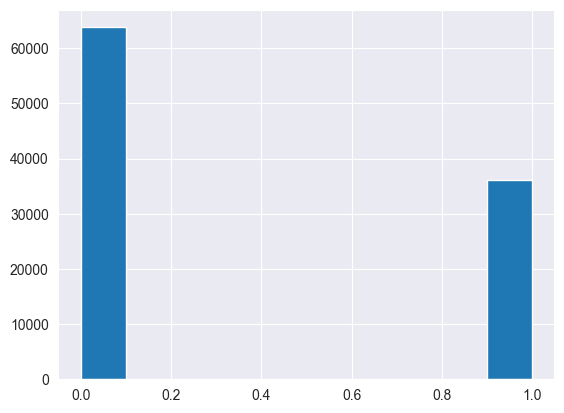

In [16]:
from matplotlib import pyplot as plt
rf=df[[ 'number_of_pedestrians_killed', 'number_of_persons_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_persons_killed',
       'number_of_pedestrians_injured',
       'number_of_motorist_killed', 'number_of_cyclist_injured']].sum(axis=1)
plt.hist(rf.apply(lambda x: 1 if x>0 else 0))

In [30]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split

def extract_day_of_year(df):
    df['crash_date'] = pd.to_datetime(df['crash_date'])
    df['day_of_year'] = df['crash_date'].dt.dayofyear
    return df.drop(columns=['crash_date'])

def pipeline(df):
    df = extract_day_of_year(df)

    cols_y = ['number_of_pedestrians_killed', 'number_of_persons_injured',
              'number_of_cyclist_killed', 'number_of_motorist_injured',
              'number_of_persons_killed', 'number_of_pedestrians_injured',
              'number_of_motorist_killed', 'number_of_cyclist_injured']

    y = df[cols_y].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    X = df.drop(cols_y, axis=1)

    categorical_features = ['vehicle_type_code1', 'contributing_factor_vehicle_1']
    numerical_features = ['latitude', 'longitude', 'day_of_year','crash_time']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ], remainder='passthrough')

    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2)

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test=pipeline(df)


In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


def evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'SVM': SVC(),
        'Logistic Regression': LogisticRegression(),
        'PCA + Logistic Regression': Pipeline([
            ('pca', PCA(n_components=5)),
            ('logreg', LogisticRegression())
        ])
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy {name}:', accuracy)
        results[name] = accuracy

    return results
evaluate_models(X_train,y_train,X_test,y_test)